## Exploring a single simulation

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
datadir = '/scratch/rfischer/Kooi_data/data_output/'
regions = {'EqPac': 'Equatorial Pacific',
           'GPGP': 'Great Pacific Garbage Patch',
           'SO': 'Southern Ocean'}

In [3]:
r_pl_clist = ['#fbb4b9', '#f768a1', '#c51b8a', '#7a0177']
r_pl_cmap = plt.get_cmap('RdPu_r')

In [57]:
region = 'SO'
mortality = 0.16              # [d-1]
runtime = 2                  # [days]
dt = 60                      # [seconds]
outputdt = 12                  # [hours]
mixing = 'fixed'
rho_p = 920
sizebinedges = [1e-3, 0.5e-3, 1e-4, 1e-5, 1e-6]

In [58]:
# ds = xr.open_dataset(datadir+'regional_GPGP_bfadv_Jan_2004_3D_grid2x2_allrho_allr_20days_60dtsecs_12hrsoutdt.nc')
ds = xr.open_dataset(datadir+'regional_'+region+'_bfadv_Jan_2004_0'+str(mortality)[2:]+'mort_'+mixing+'mixing_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')

In [63]:
ds

<xarray.Dataset>
Dimensions:     (obs: 5, traj: 10000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float64 ...
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    u           (traj, obs) float32 ...
    v           (traj, obs) float32 ...
    w           (traj, obs) float32 ...
    density     (traj, obs) float32 ...
    tpp3        (traj, obs) float32 ...
    d_phy       (traj, obs) float32 ...
    a           (traj, obs) float32 ...
    a_coll      (traj, obs) float32 ...
    a_growth    (traj, obs) float32 ...
    a_resp      (traj, obs) float32 ...
    kin_visc    (traj, obs) float32 0.0 1.729053e-06 ... 1.471482e-06
    sw_visc     (traj, obs) float32 ...
    vs          (traj, obs) float32 ...
    w_m         (traj, obs) float32 ...
    mld         (traj, obs) float32 ...
    rho_tot     (traj, obs) float32 ...
    r_tot       (traj, obs) float32 ...
    delta_rho   (traj, obs) float32 ...
    vs_init     (traj, obs) float32 ...
    r_pl        (traj) float32 0.0005573303 0.00089890807 ... 1.3471544e-06
    rho_pl      (traj) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2.dev380+gdc6262e2
    parcels_mesh:           spherical
    mortality rate:         0.16

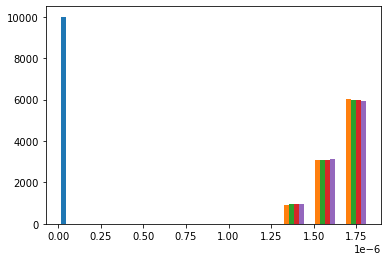

In [59]:
plt.hist(ds['kin_visc'])
plt.show()

In [60]:
number_of_trajectories_to_plot = 125
n_plt = number_of_trajectories_to_plot
f_plt = int(np.round(len(ds['traj'])/n_plt))
print('plotting '+str(n_plt)+' of '+str(len(ds['traj']))+' trajectories')
print('plotting every '+str(f_plt)+' particles')

plotting 125 of 10000 trajectories
plotting every 80 particles


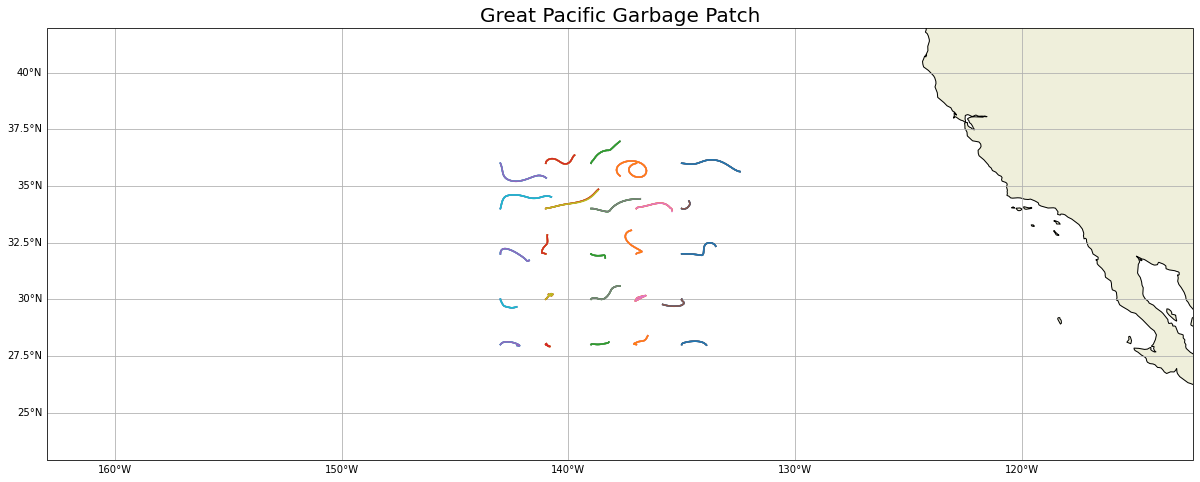

In [41]:
fig = plt.figure(figsize=(16,8), constrained_layout=True)
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_title(regions[region], fontsize=20)
ax.plot(ds['lon'].T,ds['lat'].T)
ax.coastlines()
ax.add_feature(cfeature.LAND)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.set_ylim(np.min(ds['lat'])-5,np.max(ds['lat'])+5)
ax.set_xlim(np.min(ds['lon'])-20,np.max(ds['lon'])+20)
plt.show()

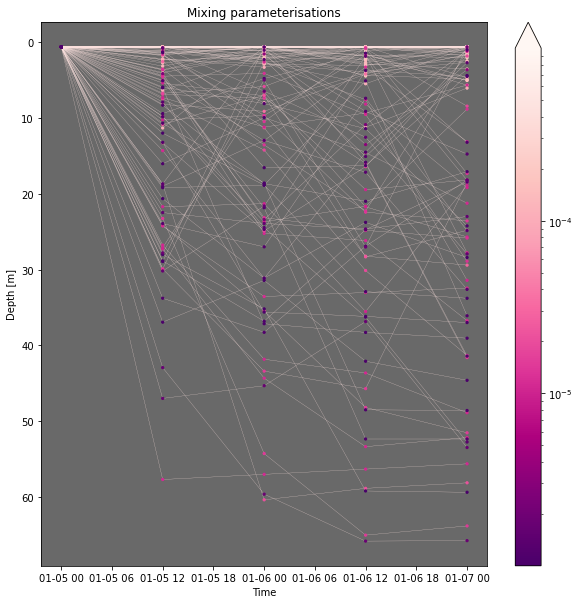

In [61]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()

sc = ax.scatter(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], s=5, c=np.tile(ds['r_pl'].T[::f_plt],[len(ds['obs']),1]),cmap=r_pl_cmap,norm=mcolors.LogNorm(vmin=ds['r_pl'].min(), vmax=ds['r_pl'].max()),zorder=2)
ln = ax.plot(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax.set_title('Mixing parameterisations')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Time')
ax.set_facecolor('dimgray')
# ax.set_ylim(150,0)
ax.invert_yaxis()

fig.colorbar(sc, ax=ax, extend='max')
plt.show()

In [62]:
sizebinedges[::-1]

[1e-06, 1e-05, 0.0001, 0.0005, 0.001]

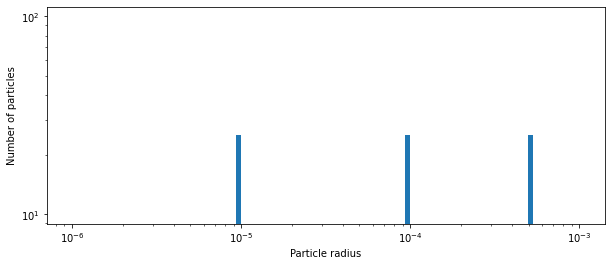

In [44]:
fig = plt.figure(figsize=(10,4)),
ax=plt.axes()
ax.hist(ds['r_pl'],np.logspace(np.log10(ds['r_pl'].min()).round(),np.log10(ds['r_pl'].max()).round(),100))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Number of particles')
ax.set_xlabel('Particle radius')
plt.show()

In [45]:
split_ds = list(ds.groupby_bins('r_pl',sizebinedges[::-1]))

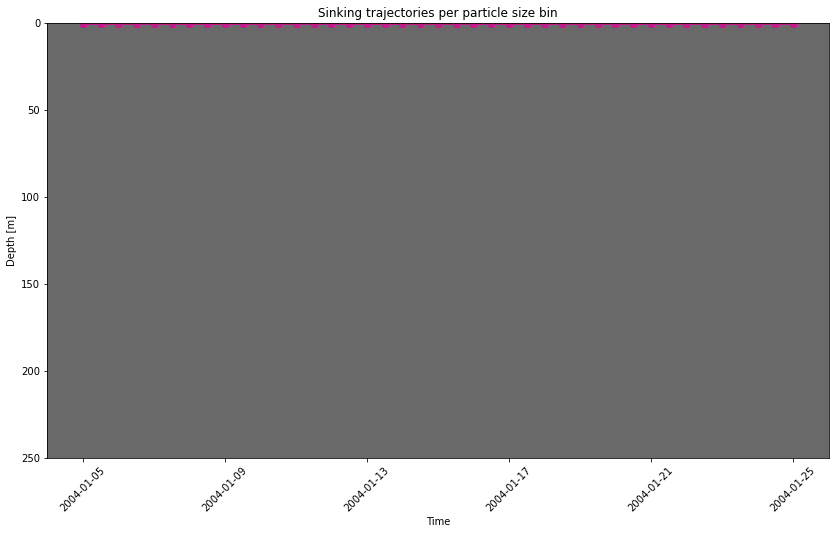

In [47]:
fig = plt.figure(figsize=(14,8))
ax=plt.axes()

for i, r in enumerate(split_ds):
    ax.plot(r[1]['time'].T[:,::f_plt], r[1]['z'].T[:,::f_plt], marker='o', markersize=6, c=r_pl_clist[i], alpha=0.4)
ax.set_facecolor('dimgray')
ax.set_ylim(250,0)
ax.set_title('Sinking trajectories per particle size bin')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Time')
ax.tick_params(axis='x', rotation=45)

custom_lines = [Line2D([0], [0], color=r_pl_clist[0], lw=4),
                Line2D([0], [0], color=r_pl_clist[1], lw=4),
                Line2D([0], [0], color=r_pl_clist[2], lw=4),
                Line2D([0], [0], color=r_pl_clist[3], lw=4)]

ax.legend(custom_lines, ["{left:.1e} - {right:.1e}".format(left=split_ds[0][0].left, right=split_ds[0][0].right), "{:.1e} - {:.1e}".format(split_ds[1][0].left, split_ds[1][0].right), "{:.1e} - {:.1e}".format(split_ds[2][0].left, split_ds[2][0].right), "{:.1e} - {:.1e}".format(split_ds[3][0].left, split_ds[3][0].right)], title='Plastic Radius', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()